# Prostate Cancer Detection

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import f1_score, plot_roc_curve

from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier as RF, AdaBoostClassifier as AB, GradientBoostingClassifier as GB
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DT

In [2]:
plt.style.use("bmh")
config = {'figure.figsize': (16, 4), 
          'axes.titlesize': 18, 
          'axes.labelsize': 14, 
          'lines.linewidth': 2, 
          'lines.markersize': 10, 
          'xtick.labelsize': 10,
          'ytick.labelsize': 10, 
          'axes.prop_cycle': plt.cycler(color=["darkmagenta", "saddlebrown", "darkcyan", "olivedrab", "darkseagreen", "darkkhaki", "darkgoldenrod", "deepskyblue", "firebrick", "palevioletred"]),}
plt.rcParams.update(config)

# Data Preprocessing

In [3]:
cancer_df = pd.read_csv('datasets/ProstateCancer.csv', index_col='id')
cancer_df.head()

,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
id,,,,,,,,,
1,M,23,12,151,954,0.143,0.278,0.242,0.079
2,B,9,13,133,1326,0.143,0.079,0.181,0.057
3,M,21,27,130,1203,0.125,0.160,0.207,0.060
4,M,14,16,78,386,0.070,0.284,0.260,0.097
5,M,9,19,135,1297,0.141,0.133,0.181,0.059


In [4]:
# Check for null values
cancer_df.isnull().values.all()

False

In [5]:
cancer_df.loc[cancer_df['diagnosis_result'] == 'B', 'diagnosis_result'] = 0
cancer_df.loc[cancer_df['diagnosis_result'] == 'M', 'diagnosis_result'] = 1

In [6]:
_, counts = np.unique(cancer_df['diagnosis_result'], return_counts=True)
print(f'Benign Diagnosis: {counts[0]}')
print(f'Malignant Diagnosis: {counts[1]}')

Benign Diagnosis: 38
Malignant Diagnosis: 62


#### X, y

In [7]:
X = cancer_df.drop('diagnosis_result', axis=1).to_numpy()
y = cancer_df['diagnosis_result'].to_numpy().astype(int)

#### Feature Scaling

In [ ]:
X_scaled = StandardScaler().fit_transform(X)

#### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Polynomial Features

Three polynomial features will be added to the data set.

In [ ]:
polynomial_features = PolynomialFeatures(3).fit(X_train)
X_train_poly = polynomial_features.transform(X_train)
X_test_poly = polynomial_features.transform(X_test)

#### LDA transformation

The data with polynomial features will be transformed into a $(n-1) \times 1$ vector with LDA, where $n$ is the number of classes. As $n=1$, the transformation results into a unidimensional feature vector.

In [ ]:
lda_transformation = LDA().fit(X_train_poly, y_train)
X_train_transformed = lda_transformation.transform(X_train_poly)
X_test_transformed = lda_transformation.transform(X_test_poly)

# Model Comparison

Several machine learning models will be compared, along with a dummy classifier which always predicts "malignant".

## Evaluation Metric

The accuracy is not an appropriate metric to evaluate the algorithm's performance, as the fraction of observation well-diagnosed is not relevant to the study. In an imbalanced set, classifying correctly the most frequent class and misclassifying the second class makes the algorithm useless. Instead, it is of interest to know

* How many people were labeled as cancer-positive from all the actual cancer-positive people (precision).

* From all the people labeld as cancer-positive, how many of them actually have cancer (recall).
 
The harmonical mean between precision and recall, the F1-Score, will be used as evaluation metric.

## Train with Repeated Stratified K-Fold Cross-validation

In [15]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=300, random_state=1)

algorithms = [DummyClassifier(strategy="most_frequent"), RF(), AB(), GB(), LDA(), NB(), LR(), SVC(), kNN(), DT()]

names = ['Most Frequent', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'LDA', 'Naive Bayes', 'Logistic Regression', 'SVM', 'kNN', 'DT']

In [9]:
f1_lists = []
for algorithm in tqdm(algorithms):
    
    if algorithm.__class__.__name__== 'DummyClassifier':
        cv_results = cross_validate(algorithm, X_train, y_train, scoring={'f1': 'f1'}, cv=cv, n_jobs=-1)
        f1_lists.append(cv_results['test_f1'])
        continue
        
    cv_results = cross_validate(algorithm, X_train_transformed, y_train, scoring={'f1': 'f1'}, cv=cv, n_jobs=-1)
    f1_lists.append(cv_results['test_f1'])

  0%|          | 0/10 [00:00<?, ?it/s]

## Confidence Intervals for Mean of F1-Score

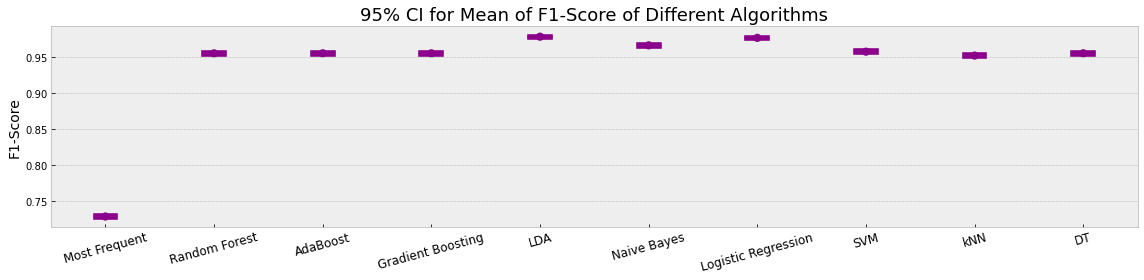

In [26]:
ax = sns.pointplot(data=f1_lists, estimator=np.mean, join=False, capsize=0.2, scale=0.7)
ax.set_xticklabels(names, fontsize=12, rotation=15)
plt.ylabel('F1-Score')
plt.title('95% CI for Mean of F1-Score of Different Algorithms')
plt.tight_layout()
plt.show()

In [17]:
bootstrap_samples = 10_000

print('95% CI for Mean of F1-Score\n')

for f1, name in zip(f1_lists, names):
    f1_bootstrapped = np.random.choice(f1, size=(len(f1), bootstrap_samples))
    f1_bootstrapped_mean = f1_bootstrapped.mean(axis=0)
    print(f'({np.quantile(f1_bootstrapped_mean, 0.025):.3f}, {np.quantile(f1_bootstrapped_mean, 0.975):.3f}) - {name}')

95% CI for Mean of F1-Score

(0.726, 0.730) - Most Frequent
(0.952, 0.957) - Random Forest
(0.952, 0.957) - AdaBoost
(0.952, 0.957) - Gradient Boosting
(0.976, 0.980) - LDA
(0.964, 0.968) - Naive Bayes
(0.974, 0.978) - Logistic Regression
(0.955, 0.959) - SVM
(0.949, 0.954) - kNN
(0.952, 0.957) - DT


## Test

Linear Discriminant Analysis will be chosen as the optimal classification algorithm.

In [23]:
y_hat = LDA().fit(X_train_transformed, y_train).predict(X_test_transformed)
f1_score(y_test, y_hat)

0.9032258064516129

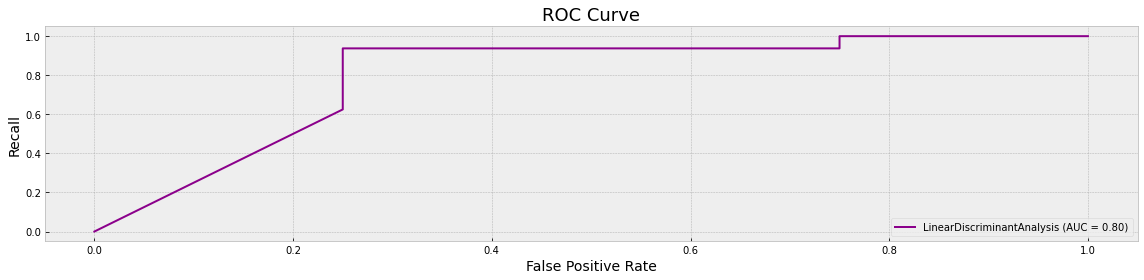

In [33]:
plot_roc_curve(LDA().fit(X_train_transformed, y_train), X_test_transformed, y_test)  
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.tight_layout()
plt.show()

# References

https://www.kaggle.com/sajidsaifi/prostate-cancer?select=Prostate_Cancer.csv